In [74]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import json
import requests
import tensorflow
import warnings
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Conv3D, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns  
from sklearn.metrics import mean_absolute_error
from keras.initializers import Constant
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from keras.models import load_model
warnings.filterwarnings('ignore')


In [75]:
crypto=input("Enter Choice of Crypto using their abbreviation (BTC,ETH, etc)\n")
fiat=input("Enter Choice of Currency using their abbreviation (INR,USD, etc)\n")
limit=input("Enter the time frame (0-2000)\n")
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym='+crypto+'&tsym='+fiat+'&limit='+str(limit))
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

hist=hist[hist['close']!=0]

hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [7]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
 

In [8]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=5):
    fig, ax = plt.subplots(1, figsize=(14, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_xlabel(crypto, fontsize=14)
    ax.set_ylabel(fiat, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    plt.show()

In [9]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

# def scaler_func(df):
#     return scaler.fit_transform()

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [10]:
def extract_window_data(df, window_len=10, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
    # for idx in range(len(df)):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [76]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col)

<font size='6'>LSTM MODEL.

In [8]:
def build_lstm_model(input_data, output_size, neurons=256, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

np.random.seed(42)
window_len = 10
test_size = 0.2
zero_base = True
lstm_neurons = 512
epochs = 75
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [9]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons,activ_func='linear', dropout=dropout, loss=loss,optimizer=optimizer)
# history = History()
history = model.fit(X_train, 
            y_train, 
            validation_data=(X_test, y_test), 
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=1, 
            shuffle=True,
            )


Epoch 1/75
50/50 [==============================] - 7s 114ms/step - loss: 0.0080 - val_loss: 0.0020
Epoch 2/75
50/50 [==============================] - 5s 107ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 3/75
50/50 [==============================] - 5s 107ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 4/75
50/50 [==============================] - 5s 109ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 5/75
50/50 [==============================] - 5s 109ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 6/75
50/50 [==============================] - 5s 109ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 7/75
50/50 [==============================] - 5s 109ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 8/75
50/50 [==============================] - 5s 109ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 9/75
50/50 [==============================] - 5s 109ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 10/75
50/50 [==============================] - 5s 109ms/step - loss: 0.0024 - val_loss: 0.0012

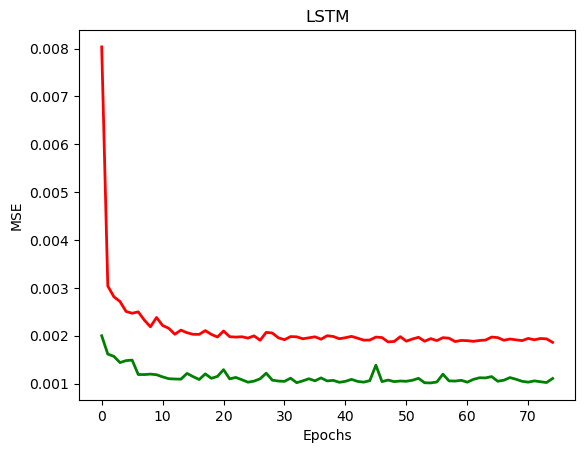

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
# plt.plot(history.history['val_accuracy'], 'b',linewidth=2, label='Validation Accuracy')
# # plt.plot(history.history['accuracy'], 'y',linewidth=2, label='Train Accuracy')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [11]:
def save_model():
    model.save('cryptomodel.h5')

In [12]:
def cnn_model(input_data, output_size, activ_func='linear',dropout=0.2, loss='mse', optimizer='adam'):
    
    model = Sequential()
    
    
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu', input_shape=(10, 6)))

    
    model.add(MaxPooling1D(pool_size=2))

    
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))

   
    model.add(MaxPooling1D(pool_size=2))
    
    
    model.add(Flatten())

   
    model.add(Dropout(0.2))

    
    model.add(Dense(128, activation='relu'))

   
    model.add(Dropout(0.3))

    
    model.add(Dense(1, activation='linear'))


    model.compile(loss=loss, optimizer=optimizer)
    
    return model
    


In [13]:
model1 = cnn_model(X_train, output_size=1,activ_func='linear', dropout=0.2, loss='mse',optimizer='adam')
history1 = model1.fit(X_train, 
            y_train, 
            validation_data=(X_test, y_test), 
            epochs=100, 
            batch_size=32, 
            verbose=1, 
            shuffle=True,
            )

Epoch 1/100
50/50 [==============================] - 1s 5ms/step - loss: 0.0251 - val_loss: 0.0058
Epoch 2/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0039
Epoch 3/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0037
Epoch 4/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0028
Epoch 5/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 6/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0029
Epoch 7/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 8/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 9/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0029
Epoch 10/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 11/

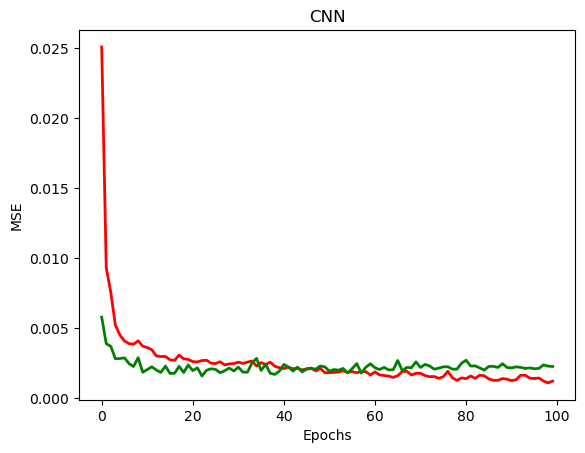

In [14]:
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history1.history['val_loss'], 'g',linewidth=2, label='Validation loss')
# plt.plot(history.history['val_accuracy'], 'b',linewidth=2, label='Validation Accuracy')
# # plt.plot(history.history['accuracy'], 'y',linewidth=2, label='Train Accuracy')
plt.title('CNN')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [124]:
targets = hist[target_col][:-10]
preds = model.predict(X_test).squeeze()

3/3 [==============================] - 0s 10ms/step


In [125]:
mae=mean_absolute_error(preds, y_test)
print("Mean Absolute Error = "+str(mae))

Mean Absolute Error = 0.027217076100605968


In [126]:
MSE=mean_squared_error(preds, y_test)
print("Mean Squared Error = "+str(MSE))

Mean Squared Error = 0.0013989393231749756


In [131]:
R2=r2_score(y_test, preds)
print(R2)

0.8971344200188068


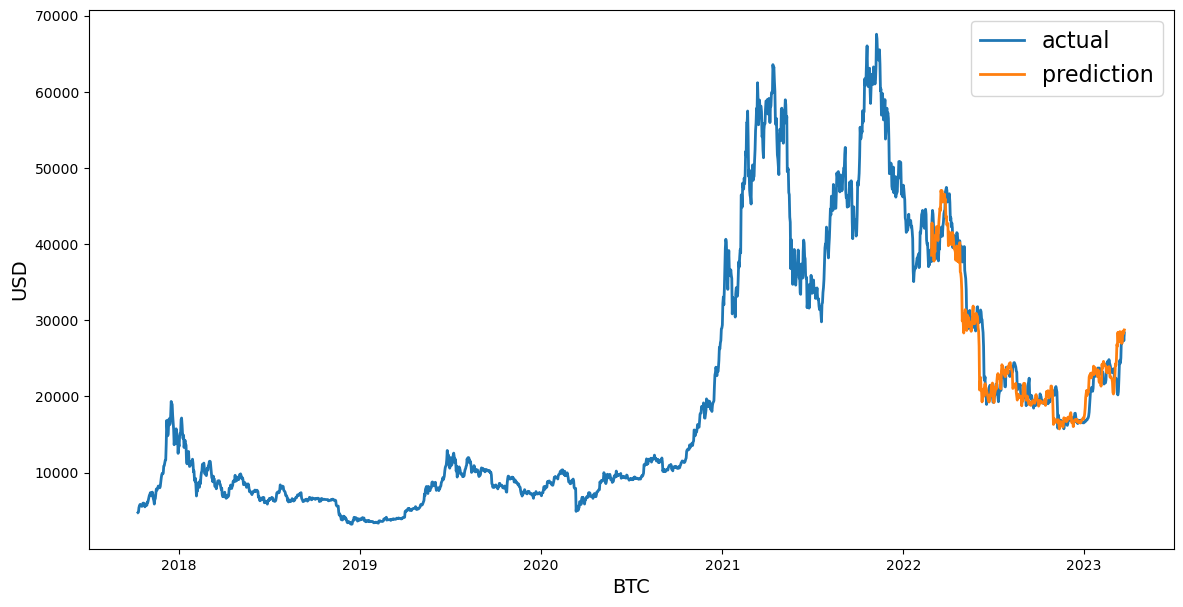

In [19]:
preds = test[target_col].values[:-10] * (preds+1)
preds = pd.Series(index=test[target_col].index[:-10], data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=2)

In [20]:
ch=input("Do you want to save the model? (Y/N)")
if(ch=='Y'):
    save_model()

In [81]:
model = load_model('cryptomodel.h5')

In [113]:
fore_data = hist
# future_timestamps = pd.date_range(start=pd.date_range(start=fore_data.index[-1], periods=2, freq='D')[1], periods=20, freq='D')
# future_df = pd.DataFrame(columns=fore_data.columns,index=future_timestamps)
# fore_data = pd.concat([fore_data, future_df])
for i in range(10):
    input_value = (np.array(fore_data[-10:]).reshape(1,10,6))
    
    fore_data_scaled = input_value/input_value[0][0] - 1 #scaling
    
    fore_pred = model.predict(fore_data_scaled)
    
    fore_pred = (fore_pred + 1) * input_value[0][0]#reverse scaling
    
    first_valid_index = fore_data.apply(lambda row: row.first_valid_index(), axis=1)
    new_index = pd.DatetimeIndex([(first_valid_index.index[-1] + pd.Timedelta(days=1))])
    new_row_df = pd.DataFrame(data=fore_pred, index=new_index, columns=fore_data.columns)
    fore_data = pd.concat([fore_data, new_row_df], axis=0)



1/1 [==============================] - 0s 14ms/step


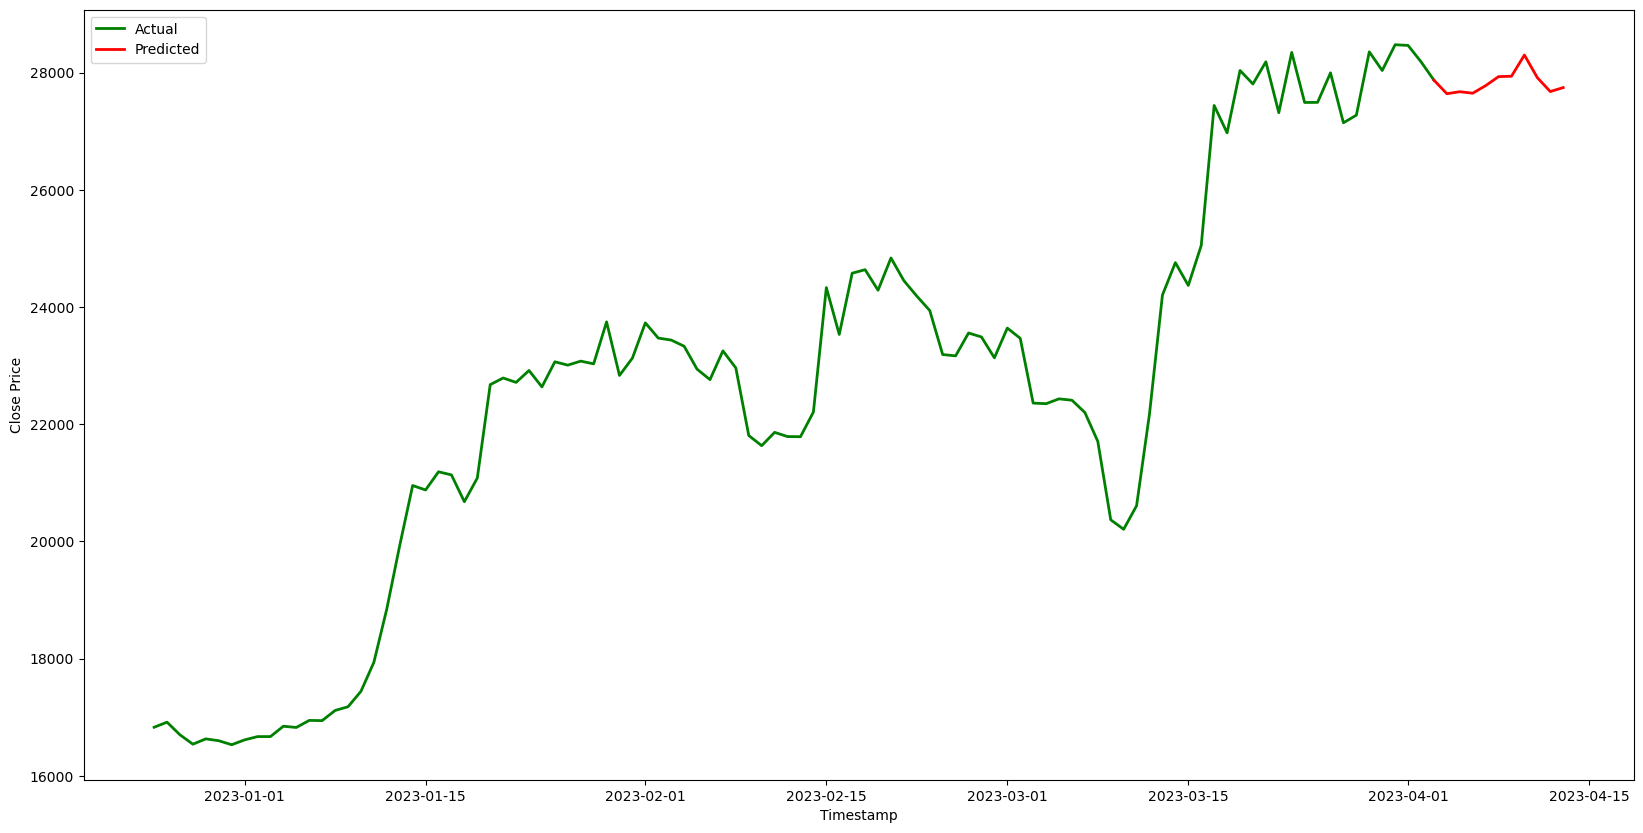

In [114]:
plt.figure(figsize=(20,10))

plt.plot(hist['close'][-100:],'g',linewidth=2,label = 'Actual')
plt.plot(fore_data['close'][-11:],'r',linewidth=2,label = 'Predicted')
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.show()


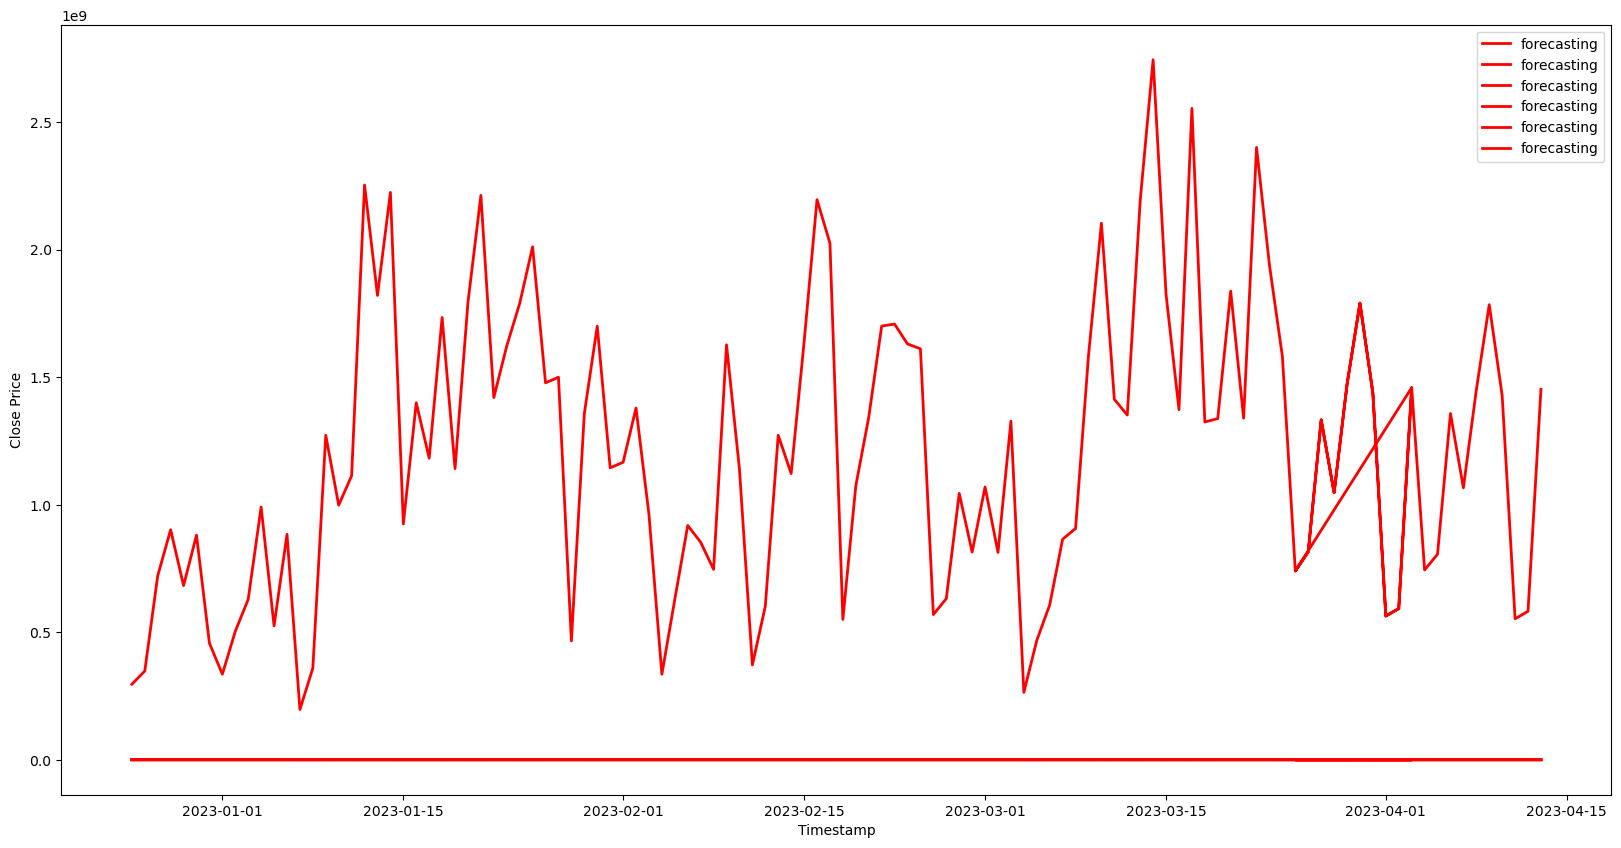

In [99]:
plt.figure(figsize=(20,10))
plot_df = pd.concat([hist[-100:],fore_data[-10:]])
plt.plot(plot_df,'r',lw=2,label='forecasting')
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.show()
